<a href="https://colab.research.google.com/github/LawTAGS/Deep-Learning-Classwork/blob/main/DL_VAE_Clustering_Problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50
29/29 - 3s - 100ms/step - loss: 0.1529
Epoch 2/50
29/29 - 0s - 7ms/step - loss: 0.1340
Epoch 3/50
29/29 - 0s - 5ms/step - loss: 0.1295
Epoch 4/50
29/29 - 0s - 9ms/step - loss: 0.1272
Epoch 5/50
29/29 - 0s - 5ms/step - loss: 0.1277
Epoch 6/50
29/29 - 0s - 5ms/step - loss: 0.1270
Epoch 7/50
29/29 - 0s - 3ms/step - loss: 0.1271
Epoch 8/50
29/29 - 0s - 5ms/step - loss: 0.1266
Epoch 9/50
29/29 - 0s - 3ms/step - loss: 0.1260
Epoch 10/50
29/29 - 0s - 5ms/step - loss: 0.1264
Epoch 11/50
29/29 - 0s - 5ms/step - loss: 0.1275
Epoch 12/50
29/29 - 0s - 5ms/step - loss: 0.1261
Epoch 13/50
29/29 - 0s - 4ms/step - loss: 0.1263
Epoch 14/50
29/29 - 0s - 4ms/step - loss: 0.1272
Epoch 15/50
29/29 - 0s - 5ms/step - loss: 0.1268
Epoch 16/50
29/29 - 0s - 4ms/step - loss: 0.1267
Epoch 17/50
29/29 - 0s - 4ms/step - loss: 0.1258
Epoch 18/50
29/29 - 0s - 5ms/step - loss: 0.1260
Epoch 19/50
29/29 - 0s - 5ms/step - loss: 0.1269
Epoch 20/50
29/29 - 0s - 5ms/step - loss: 0.1257
Epoch 21/50
29/29 - 0s - 5m

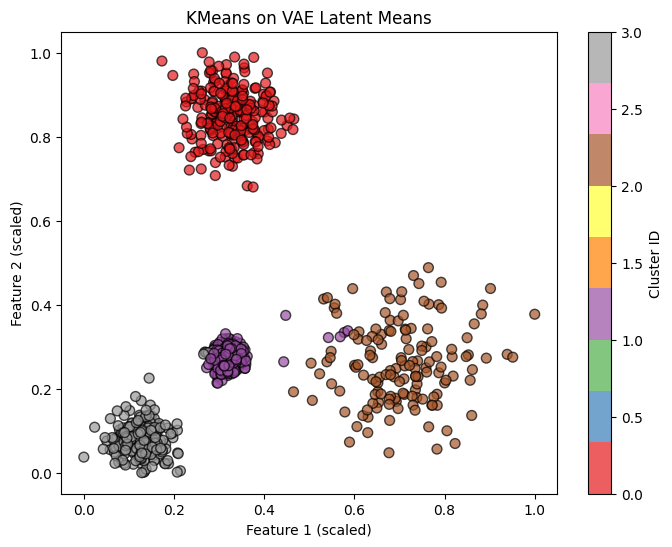

In [ ]:
import numpy as np                             # Numerical operations
import matplotlib.pyplot as plt                # Plotting
from sklearn.preprocessing import MinMaxScaler # Feature scaling
from sklearn.cluster import KMeans             # K-Means clustering
import tensorflow as tf                        # TensorFlow core
from tensorflow.keras import layers, Model     # Keras layers & Model
from tensorflow.keras.losses import mse        # Mean squared error loss
from tensorflow.keras import backend as K      # Keras backend ops

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# ========================================
# 1. Generalized 2D Data Generator with M cluster centers
# ========================================
def generate_2d_data(centers, n_samples, scales=None, random_state=None):
    """
    Generates multi-cluster 2D Gaussian data.
    Parameters
    ----------
    centers : list of tuple(float, float)
        The (x,y) coordinates of each cluster center.
    n_samples : int or list of int
        If int, generate the same number of points for each center.
        If list, must match len(centers), samples per corresponding center.
    scales : None, float, or list of float
        Standard deviation for each cluster. If None, defaults to 0.3 for all.
        If float, uses same scale for all clusters.
        If list, must match len(centers).
    random_state : int or None
        Seed for NumPy RNG.
    Returns
    -------
    data : np.ndarray, shape (sum(n_samples), 2)
        The generated 2D points.
    labels : np.ndarray, shape (sum(n_samples),)
        Cluster ID labels in {0, 1, …, M−1}.
    """
    if random_state is not None:
        np.random.seed(random_state)

    M = len(centers)
    if isinstance(n_samples, int):
        n_samples = [n_samples] * M
    elif len(n_samples) != M:
        raise ValueError("n_samples list must match number of centers")

    if scales is None:
        scales = [0.3] * M
    elif isinstance(scales, (float, int)):
        scales = [float(scales)] * M
    elif len(scales) != M:
        raise ValueError("scales list must match number of centers")

    data_list, label_list = [], []
    for idx, ((cx, cy), n, s) in enumerate(zip(centers, n_samples, scales)):
        pts = np.random.normal(loc=(cx, cy), scale=s, size=(n, 2))
        data_list.append(pts)
        label_list.append([idx] * n)

    data = np.vstack(data_list)
    labels = np.concatenate(label_list)
    return data, labels

# Example: clusters center
centers = [(1,1), (4,2), (2,5) ,(2,2)]
n_samples = [200, 150, 250, 300]
scales = [0.2, 0.5, 0.3, 0.1]
data, labels = generate_2d_data(centers, n_samples, scales, random_state=42)

# ========================================
# 2. Scale data to [0,1]
# ========================================
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# ========================================
# 3. Define the Variational Autoencoder (VAE)
# ========================================
def sampling(args):
    """Reparameterization: z = μ + σ * ε."""
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim   = K.int_shape(z_mean)[1]
    eps   = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * eps

class VAE(Model):
    def __init__(self, input_dim=2, latent_dim=2):
        super().__init__()
        # Encoder
        self.dense_e = layers.Dense(64, activation='relu')
        self.z_mean  = layers.Dense(latent_dim, name='z_mean')
        self.z_log   = layers.Dense(latent_dim, name='z_log_var')
        self.sampler = layers.Lambda(sampling, name='z')
        # Decoder
        self.dense_d = layers.Dense(64, activation='relu')
        self.out     = layers.Dense(input_dim, activation='sigmoid')

    def call(self, inputs):
        h = self.dense_e(inputs)
        z_m = self.z_mean(h)
        z_l = self.z_log(h)
        z   = self.sampler([z_m, z_l])
        h2 = self.dense_d(z)
        x_hat = self.out(h2)
        recon_loss = mse(inputs, x_hat) * K.int_shape(inputs)[1]
        kl = -0.5 * K.sum(1 + z_l - K.square(z_m) - K.exp(z_l), axis=1)
        self.add_loss(K.mean(recon_loss + kl))
        return x_hat

# ========================================
# 4. Train the VAE
# ========================================
vae = VAE(input_dim=2, latent_dim=2)
vae.compile(optimizer='adam')
vae.fit(data_scaled, epochs=50, batch_size=32, verbose=2)

# ========================================
# 5. Extract Latent Means for Clustering
# ========================================
encoder_input = layers.Input(shape=(2,))
h_enc = vae.dense_e(encoder_input)
z_mean_enc = vae.z_mean(h_enc)
encoder_model = Model(encoder_input, z_mean_enc)
latent_means = encoder_model.predict(data_scaled)

# ========================================
# 6. Cluster in Latent Space with KMeans
# ========================================
kmeans = KMeans(n_clusters=4, random_state=0)
cluster_ids = kmeans.fit_predict(latent_means)

# ========================================
# 7. Plot Original Data Colored by Cluster
# ========================================
plt.figure(figsize=(8,6))
plt.scatter(
    data_scaled[:,0], data_scaled[:,1],
    c=cluster_ids, cmap='Set1', s=50, edgecolor='k', alpha=0.7
)
plt.title('KMeans on VAE Latent Means')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.colorbar(label='Cluster ID')
plt.show()
